# Parker Solar Probe data

The parameters are:

- 'psp_fld_l2_mag_RTN_4_Sa_per_Cyc' (B in RTN, 0.25s resolution)
- 'psp_swp_spi_sf00_L3_DENS' (Ion density, regular resolution)
- 'psp_swp_spi_af00_L3_DENS' (Ion density, burst resolution)
- 'psp_swp_spi_sf00_L3_VEL_RTN_SUN' (velocity in RTN in Sun's frame, regular resolution)
- 'psp_swp_spi_af00_L3_VEL_RTN_SUN' (velocity in RTN in Sun's frame, burst resolution)
- 'psp_swp_spi_sf00_L3_VEL_RTN' (velocity in RTN in spacecraft frame, regular resolution, you need this to calculate current sheet thickness)
- 'psp_swp_spi_af00_L3_VEL_RTN' (velocity in RTN in spacecraft frame, burst resolution, you need this to calculate current sheet thickness)
- 'Tp_spani_b' (Ion parallel and perpendicular ion temperature, regular resolution. Blue (first element in array): parallel, Red: perp)
- 'Tp_spanib_b' (Ion parallel and perpendicular ion temperature, burst resolution. Blue (first element in array): parallel, Red: perp)

In [1]:
from pytplot import tplot_restore, tplot_names, tplot, get_data
from discontinuitypy import IDsDataset
from space_analysis.ds.meta import Meta, PlasmaMeta, TempMeta
import polars as pl
import numpy as np
from utils.temp import calc_pressure_anisotropy

In [2]:
enc = 7
tau = 16
name = 'psp'
file_name = f"../data/psp_e{enc:02}.tplot"

In [3]:
tplot_restore(file_name)
tnames = tplot_names()

0 : psp_fld_l2_mag_RTN_4_Sa_per_Cyc
1 : psp_swp_spi_sf00_L3_DENS
2 : psp_swp_spi_sf00_L3_VEL_RTN_SUN
3 : psp_swp_spi_sf00_L3_VEL_RTN
4 : psp_swp_spi_af00_L3_DENS
5 : psp_swp_spi_af00_L3_VEL_RTN_SUN
6 : psp_swp_spi_af00_L3_VEL_RTN
7 : Tp_spani_b
8 : Tp_spanib_b


In [4]:
def get_data_lf(name):
    da = get_data(name, xarray=True)
    df = da.to_pandas().reset_index()
    return pl.LazyFrame(df).with_columns(
        pl.col("time").dt.cast_time_unit('us'),
    )

density_col = 'plasma_density'
velocity_cols = ['v_R', 'v_T', 'v_N']

mag_data = get_data_lf('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')
density_data = get_data_lf('psp_swp_spi_sf00_L3_DENS').rename({'0': density_col})
velocity_data = get_data_lf('psp_swp_spi_sf00_L3_VEL_RTN').rename({'0': 'v_R', '1': 'v_T', '2': 'v_N'}) # velocity in RTN in spacecraft frame, regular resolution, you need this to calculate current sheet thickness
ion_temp_data = get_data_lf('Tp_spani_b').rename({'0': 'ion_temp_para', '1': 'ion_temp_perp'})
# ion_temp_burst_data = get_data_lf('Tp_spanib_b').rename({'0': 'ion_temp_para_burst', '1': 'ion_temp_perp_burst'})

plasma_data = density_data.join(velocity_data, on='time')

plasma_meta = PlasmaMeta(
    density_col=density_col,
    velocity_cols=velocity_cols,
)

11-May-24 12:44:01: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

11-May-24 12:44:01: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

11-May-24 12:44:01: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

11-May-24 12:44:01: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [5]:
time = mag_data.collect().get_column("time").to_numpy()
ts = np.median(np.diff(time)).item()

In [6]:
ids_dataset = IDsDataset(
    name=name,
    mag_data=mag_data,
    tau=tau,
    ts=ts,
    ion_temp_data = ion_temp_data,
    plasma_data=plasma_data,
    plasma_meta=plasma_meta
    
)
ids_dataset.find_events().update_events()

ids_dataset.events = ids_dataset.events.pipe(calc_pressure_anisotropy)

11-May-24 12:44:05: UserWarning: Ray execution environment not yet initialized. Initializing...
To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()


11-May-24 12:44:05: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-05-11_12-44-05_931351_17046/logs/gcs_server.out' mode='a' encoding='utf-8'>

11-May-24 12:44:05: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-05-11_12-44-05_931351_17046/logs/gcs_server.err' mode='a' encoding='utf-8'>

11-May-24 12:44:06: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-05-11_12-44-05_931351_17046/logs/monitor.out' mode='a' encoding='utf-8'>

11-May-24 12:44:06: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2024-05-11_12-44-05_931351_17046/logs/monitor.err' mode='a' encoding='utf-8'>

11-May-24 12:44:07: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/ses

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 11:   0%           Elapsed time: 00:00, estimated remaining time: ?

(_deploy_ray_func pid=17131) 11-May-24 12:44:15: RuntimeWarning: overflow encountered in exp
(_deploy_ray_func pid=17131) 
11-May-24 12:44:16: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

11-May-24 12:44:16: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

11-May-24 12:44:16: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

11-May-24 12:44:16: PendingDeprecationWarning: The `dims` argument has been renamed to `dim`, and will be removed in the future. This renaming is taking place throughout xarray over the next few releases.

11-May-24 12:44:16: PendingDeprecationWarning: The `d

In [ ]:
path = f"../data/enc{enc}/events.PSP.arrow"
ids_dataset.export(path)

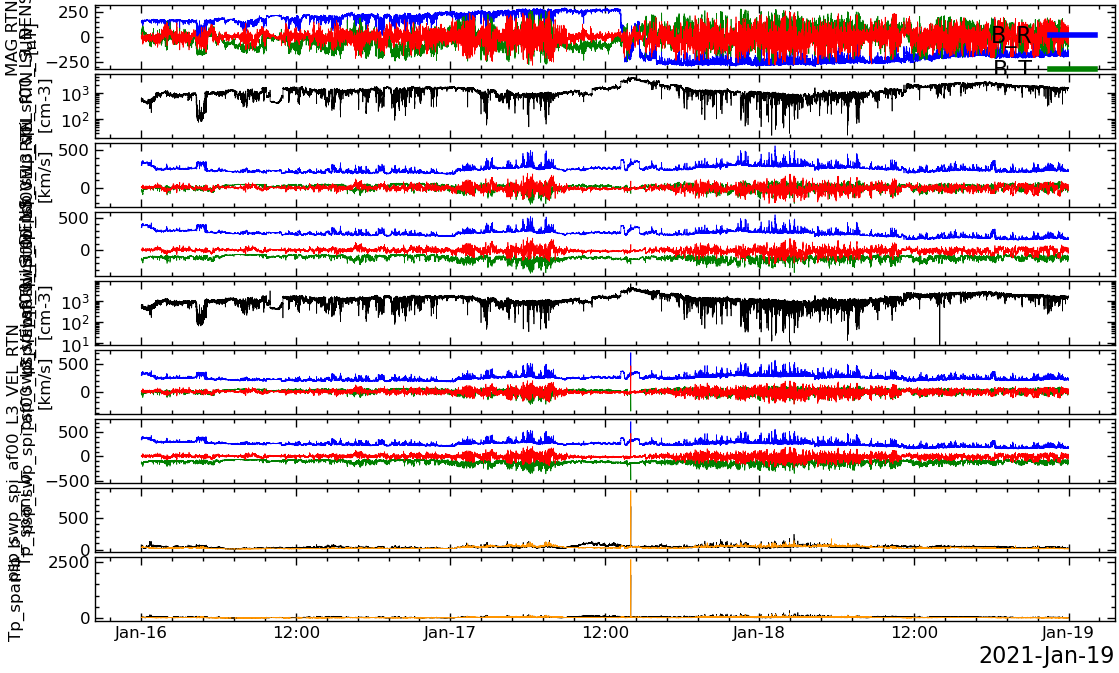

In [7]:
tplot(tnames)
tlimit(['2007-03-23/15:00','2007-03-23/17:00'])

ids_dataset